In [1]:
import sys
import torch
from matplotlib import pyplot as plt
import numpy as np

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

folder_path = '../data/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnmp_ import CNMP
from cmpe import CMPE

from data_generators import *
from positional_encoders import *
from plotters import *

torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")
# device = torch.device("cpu")
print("Device :", device)

Device : cuda:0


In [2]:
dx, dy, dg, dpe = 1, 1, 1, 27
num_demos, num_test = 32, 8
num_trajs = num_demos + num_test
t_steps = 1000
n_max, m_max = 100, 100
max_y = 0.2

all_x_train, all_x_test, all_y_train, all_y_test, all_g_train, all_g_test, all_test_cond = [], [], [], [], [], [], []
all_x, all_y = [], []

for i in range(3):
    num_peaks = 2+i

    x, y, pp = n_peaks(num_peaks, num_trajs, 0.05-i**2/100, t_steps)
    all_x.append(x)
    y_max, y_min = torch.max(y), torch.min(y)
    y = (y - y_min) / (y_max - y_min) * max_y  # Normalize y
    all_y.append(y)

    # train-test split
    test_ids = []
    while len(test_ids) < num_test:
        val_id = np.random.choice(np.arange(num_trajs), 1)
        # continue if pp[val_id] is either smallest or largest value
        # append to val_id otherwise
        if (pp[val_id, 0] == torch.max(pp[:, 0]) or pp[val_id, 0] == torch.min(pp[:, 0])):
            continue
        else:
            if val_id not in test_ids:
                test_ids.append(val_id)

    train_ids = np.setdiff1d(np.arange(num_trajs), test_ids)
    test_ids = torch.tensor(test_ids).squeeze(-1)
    train_ids = torch.from_numpy(train_ids)

    all_test_cond.append((pp[test_ids] * 200).int())

    all_y_train.append(y[train_ids].clone())
    all_y_test.append(y[test_ids].clone())

    all_x_train.append(x[train_ids].clone())
    all_x_test.append(x[test_ids].clone())

    all_g_train.append(num_peaks * torch.ones(len(train_ids), 1).int())
    all_g_test.append(num_peaks * torch.ones(len(test_ids), 1).int())

num_demos, num_test = 3*32, 3*8
num_trajs = num_demos + num_test

y_train = torch.cat(all_y_train, dim=0)
y_test = torch.cat(all_y_test, dim=0)
x_train = torch.cat(all_x_train, dim=0)
x_test = torch.cat(all_x_test, dim=0)
g_train = torch.cat(all_g_train, dim=0) / 4  # Normalize where max_peaks = 4
g_test = torch.cat(all_g_test, dim=0) / 4  # Normalize where max_peaks = 4
test_cond_ind = all_test_cond

# Print shapes
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}, g_train shape: {g_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}, g_test shape: {g_test.shape}")

all_x = torch.cat(all_x, dim=0)
all_y = torch.cat(all_y, dim=0)

x_train shape: torch.Size([96, 1000, 1]), y_train shape: torch.Size([96, 1000, 1]), g_train shape: torch.Size([96, 1])
x_test shape: torch.Size([24, 1000, 1]), y_test shape: torch.Size([24, 1000, 1]), g_test shape: torch.Size([24, 1])


/tmp/ipykernel_12523/1497596705.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  test_ids = torch.tensor(test_ids).squeeze(-1)


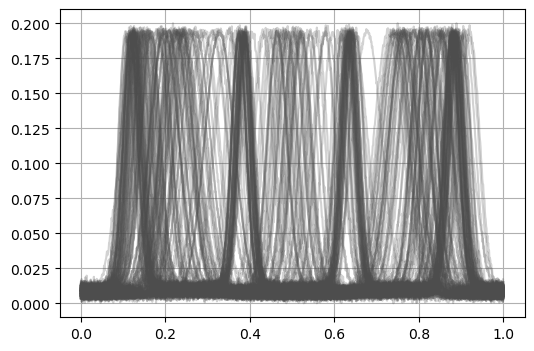

In [3]:
plot_trajs(all_x, all_y)

In [4]:
d_model = dpe
pe_code = 0
pe = pes[pe_code](length=t_steps, d_model=d_model)
dpe_aug = dpe + dg

In [5]:
batch_size = 8
window_length = 10

enc_dims = [128,128]
dec_dims = [128,128]

m0_ = CNMP(input_dim=dx+dg, output_dim=dy, n_max=n_max*window_length, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
opt0 = torch.optim.Adam(lr=3e-4, params=m0_.parameters())

m1_ = CNMP(input_dim=dpe_aug, output_dim=dy, n_max=n_max*window_length, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
opt1 = torch.optim.Adam(lr=3e-4, params=m1_.parameters())

m2_ = CMPE(input_dim=dpe_aug, output_dim=dy, n_max=n_max, m_max=m_max, window_length=window_length, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
opt2 = torch.optim.Adam(lr=3e-4, params=m2_.parameters())

pytorch_total_params = sum(p.numel() for p in m0_.parameters())
print('CNMP: ', pytorch_total_params)
pytorch_total_params = sum(p.numel() for p in m2_.parameters())
print('CMPE: ', pytorch_total_params)


if torch.__version__ >= "2.0":
    m0, m1, m2 = torch.compile(m0_), torch.compile(m1_), torch.compile(m2_)
else:
    m0, m1, m2 = m0_, m1_, m2_

CNMP:  34050
CMPE:  118274


In [6]:
obs0 = torch.zeros((batch_size, n_max*window_length, dx+dg+dy), dtype=torch.float32, device=device)
tar_x0 = torch.zeros((batch_size, m_max, dx+dg), dtype=torch.float32, device=device)

obs1 = torch.zeros((batch_size, n_max*window_length, dpe_aug+dy), dtype=torch.float32, device=device)
tar_x1 = torch.zeros((batch_size, m_max, dpe_aug), dtype=torch.float32, device=device)

obs2 = torch.zeros((batch_size, n_max, window_length, dpe_aug+dy), dtype=torch.float32, device=device)
tar_x2 = torch.zeros((batch_size, m_max, dpe_aug), dtype=torch.float32, device=device)

tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    global obs0, tar_x0, obs1, tar_x1, obs2, tar_x2, tar_y, obs_mask, tar_mask
    obs0.fill_(0)
    tar_x0.fill_(0)
    obs1.fill_(0)
    tar_x1.fill_(0)
    obs2.fill_(0)
    tar_x2.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max+1, (1,)).item()
        m = torch.randint(1, m_max+1, (1,)).item()

        permuted_ids = torch.randperm(t_steps-window_length)  # e.g 1000-10 = 990, n_id can be 990 at max since we are using window_length=10
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        window_n_ids = torch.cat([n_id + torch.arange(window_length) for n_id in n_ids])
        
        for j in range(window_length):
            obs2[i, :n, j, :dpe] = pe[n_ids+j] # PE(t)
            obs2[i, :n, j, dpe:dpe_aug] = g_train[traj_id, 0] # gamma(t)
            obs2[i, :n, j, dpe_aug:] = traj[n_ids+j]  # SM(t), SM(t+1), SM(t+2), ..., SM(t+(window_length-1))
        
        obs1 = obs2.view(batch_size, -1, dpe_aug+dy).clone()

        obs0[i, :n*window_length, :dx] = x_train[traj_id, window_n_ids]  # t_0, t_1, t_2, ..., t_(window_length-1)
        obs0[i, :n*window_length, dx:dx+dg] = g_train[traj_id, 0]  # gamma(t)
        obs0[i, :n*window_length, dx+dg:] = traj[window_n_ids]  # SM(t), SM(t+1), SM(t+2), ..., SM(t+(window_length-1))

        obs_mask[i, :n] = True
        
        tar_x0[i, :m, :dx] = x_train[traj_id, m_ids]
        tar_x0[i, :m, dx:dx+dg] = g_train[traj_id, 0]

        tar_x1[i, :m, :dpe] = pe[m_ids]
        tar_x1[i, :m, dpe:dpe_aug] = g_train[traj_id, 0]

        tar_x2 = tar_x1.clone()

        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True

test_obs0 = torch.zeros((batch_size, n_max*window_length, dx+dg+dy), dtype=torch.float32, device=device)
test_tar_x0 = torch.zeros((batch_size, t_steps, dx+dg), dtype=torch.float32, device=device)

test_obs1 = torch.zeros((batch_size, n_max*window_length, dpe_aug+dy), dtype=torch.float32, device=device)
test_tar_x1 = torch.zeros((batch_size, t_steps, dpe_aug), dtype=torch.float32, device=device)

test_obs2 = torch.zeros((batch_size, n_max, window_length, dpe_aug+dy), dtype=torch.float32, device=device)
test_tar_x2 = torch.zeros((batch_size, t_steps, dpe_aug), dtype=torch.float32, device=device)

test_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
test_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
last_obs_vals = torch.zeros((batch_size, n_max, dx), dtype=torch.int32, device=device)  # only for plotting

def prepare_masked_test_batch(t: list, traj_ids: list, fixed_ind=None):
    global test_obs0, test_tar_x0, test_obs1, test_tar_x1, test_obs2, test_tar_x2, test_tar_y, test_obs_mask, last_obs_vals
    test_obs0.fill_(0)
    test_tar_x0.fill_(0)
    test_obs1.fill_(0)
    test_tar_x1.fill_(0)
    test_obs2.fill_(0)
    test_tar_x2.fill_(0)
    test_tar_y.fill_(0)
    test_obs_mask.fill_(False)
    last_obs_vals.fill_(0)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        # n = num_peaks #torch.randint(5, n_max, (1,)).item()
        n = torch.randint(1, n_max+1, (1,)).item()

        permuted_ids = torch.randperm(t_steps-window_length)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        window_n_ids = torch.cat([n_id + torch.arange(window_length) for n_id in n_ids])

        # TODO didn't update, so check
        if fixed_ind != None:
            for p in range(n):
                n_ids[p] = fixed_ind[i, p]
            # n_ids[-1] = fixed_ind[i]
        
        for j in range(window_length):
            test_obs2[i, :n, j, :dpe] = pe[n_ids+j] # PE(t)
            test_obs2[i, :n, j, dpe:dpe_aug] = g_train[traj_id, 0] # gamma(t)
            test_obs2[i, :n, j, dpe_aug:] = traj[n_ids+j]  # SM(t), SM(t+1), SM(t+2), ..., SM(t+(window_length-1))


        test_obs1 = test_obs2.view(batch_size, -1, dpe_aug+dy).clone()

        test_obs0[i, :n*window_length, :dx] = x_test[traj_id, window_n_ids]  # t_0, t_1, t_2, ..., t_(window_length-1)
        test_obs0[i, :n*window_length, dx:dx+dg] = g_test[traj_id, 0]
        test_obs0[i, :n*window_length, dx+dg:] = traj[window_n_ids]

        last_obs_vals[i, :n] = n_ids.unsqueeze(-1)
        # test_obs[i, :n, dpe_aug:] = traj[n_ids]
        test_obs_mask[i, :n] = True
        
        test_tar_x0[i, :, :dx] = x_test[traj_id, m_ids]
        test_tar_x0[i, :, dx:dx+dg] = g_test[traj_id, 0]

        test_tar_x1[i, :, :dpe] = pe[m_ids]
        test_tar_x1[i, :, dpe:dpe_aug] = g_test[traj_id, 0]

        test_tar_x2 = test_tar_x1.clone()

        test_tar_y[i] = traj[m_ids]

In [7]:
import time
import os

peak_code = ('no' if dpe_aug==dpe else 'with') + '_num_peaks'
# arch_code = str(num_demos) + '_' + str(num_test) + '_'
# for i in enc_dims:
#     arch_code += str(i) + '_'
# arch_code = arch_code[:-1]

#timestamp = int(time.time())
# root_folder = f'../outputs/tests/{num_peaks}_peak/{pose_code}/{arch_code}/bs_{batch_size}/{str(timestamp)}/'


timestamp = int(time.time())
root_folder = f'../outputs/comparison/bare_pe_lstm/{peak_code}/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

img_folder = f'{root_folder}img/'
if not os.path.exists(img_folder):
    os.makedirs(img_folder)

torch.save(y_train, f'{root_folder}y.pt')


epochs = 500_000
epoch_iter = num_demos // batch_size
test_epoch_iter = num_test//batch_size
avg_loss0, avg_loss1, avg_loss2 = 0, 0, 0
loss_report_interval = 500
test_per_epoch = 1000
min_test_loss0, min_test_loss1, min_test_loss2 = 1000000, 1000000, 1000000
mse_loss = torch.nn.MSELoss()

plot_test = True

l0, l1, l2 = [], [], []

for epoch in range(epochs):
    epoch_loss0, epoch_loss1, epoch_loss2 = 0, 0, 0

    traj_ids = torch.randperm(num_demos)[:batch_size * epoch_iter].chunk(epoch_iter)

    for i in range(epoch_iter):
        prepare_masked_batch(y_train, traj_ids[i])

        opt0.zero_grad()
        pred0 = m0(obs0, tar_x0, obs_mask)
        loss0 = m0.loss(pred0, tar_y, tar_mask)
        loss0.backward()
        opt0.step()

        epoch_loss0 += loss0.item()


        opt1.zero_grad()
        pred1 = m1(obs1, tar_x1, obs_mask)
        loss1 = m1.loss(pred1, tar_y, tar_mask)
        loss1.backward()
        opt1.step()

        epoch_loss1 += loss1.item()


        opt2.zero_grad()
        pred2 = m2(obs2, tar_x2, obs_mask)
        loss2 = m2.loss(pred2, tar_y, tar_mask)
        loss2.backward()
        opt2.step()

        epoch_loss2 += loss2.item()


    if epoch % test_per_epoch == 0 and epoch > 0:
        test_traj_ids = torch.randperm(num_test)[:batch_size*test_epoch_iter].chunk(test_epoch_iter)
        test_loss0, test_loss1, test_loss2 = 0, 0, 0

        for j in range(test_epoch_iter):
            prepare_masked_test_batch(y_test, test_traj_ids[j])

            pred0 = m0.val(test_obs0, test_tar_x0, test_obs_mask)
            pred1 = m1.val(test_obs1, test_tar_x1, test_obs_mask)
            pred2 = m2.val(test_obs2, test_tar_x2, test_obs_mask)
            
            if plot_test:
                for k in range(batch_size):
                    current_n = test_obs_mask[k].sum().item()
                    plt.scatter(last_obs_vals[k, :current_n, :dx].cpu().numpy(), test_obs0[k, :current_n, dx+dg:].cpu().numpy(), label='Condition')
                    plt.plot(test_tar_y[k, :, 0].cpu().numpy(), label=f"Groundtruth")
                    plt.plot(pred0[k, :, 0].cpu().numpy(), label=f"Prediction")
                    
                    plt.legend()
                    plt.savefig(f'{img_folder}{epoch}_bare_{test_traj_ids[j, k]}.png')
                    plt.clf()

                    plt.scatter(last_obs_vals[k, :current_n, :dx].cpu().numpy(), test_obs1[k, :current_n, dpe_aug:].cpu().numpy(), label='Condition')
                    plt.plot(test_tar_y[k, :, 0].cpu().numpy(), label=f"Groundtruth")
                    plt.plot(pred1[k, :, 0].cpu().numpy(), label=f"Prediction")
                    
                    plt.legend()
                    plt.savefig(f'{img_folder}{epoch}_pe_{test_traj_ids[j, k]}.png')
                    plt.clf()

                    plt.scatter(last_obs_vals[k, :current_n, :dx].cpu().numpy(), test_obs2[k, :current_n, 0, dpe_aug:].cpu().numpy(), label='Condition')
                    plt.plot(test_tar_y[k, :, 0].cpu().numpy(), label=f"Groundtruth")
                    plt.plot(pred2[k, :, 0].cpu().numpy(), label=f"Prediction")
                    
                    plt.legend()
                    plt.savefig(f'{img_folder}{epoch}_lstm_{test_traj_ids[j, k]}.png')
                    plt.clf()

            test_loss0 += mse_loss(pred0[:, :, :m0.output_dim], test_tar_y).item()
            test_loss1 += mse_loss(pred1[:, :, :m1.output_dim], test_tar_y).item()
            test_loss2 += mse_loss(pred2[:, :, :m2.output_dim], test_tar_y).item()
        
        test_loss0 /= test_epoch_iter
        test_loss1 /= test_epoch_iter
        test_loss2 /= test_epoch_iter
            
        if test_loss0 < min_test_loss0:
            min_test_loss0 = test_loss0
            print(f'BARE New best: {min_test_loss0}, PE best: {min_test_loss1}, LSTM best: {min_test_loss2}')
            torch.save(m0_.state_dict(), f'{root_folder}saved_models/bare.pt')

        if test_loss1 < min_test_loss1:
            min_test_loss1 = test_loss1
            print(f'PE New best: {min_test_loss1}, BARE best: {min_test_loss0}, LSTM best: {min_test_loss2}')
            torch.save(m1_.state_dict(), f'{root_folder}saved_models/pe.pt')

        if test_loss2 < min_test_loss2:
            min_test_loss2 = test_loss2
            print(f'LSTM New best: {min_test_loss2}, BARE best: {min_test_loss0}, PE best: {min_test_loss1}')
            torch.save(m2_.state_dict(), f'{root_folder}saved_models/lstm.pt')

    epoch_loss0 /= epoch_iter
    epoch_loss1 /= epoch_iter
    epoch_loss2 /= epoch_iter

    avg_loss0 += epoch_loss0
    avg_loss1 += epoch_loss1
    avg_loss2 += epoch_loss2

    l0.append(epoch_loss0)
    l1.append(epoch_loss1)
    l2.append(epoch_loss2)

    if epoch % loss_report_interval == 0:
        print("Epoch: {}, Losses: BARE: {}, PE {}, LSTM: {}".format(epoch, avg_loss0/loss_report_interval, avg_loss1/loss_report_interval, avg_loss2/loss_report_interval))
        avg_loss0, avg_loss1, avg_loss2 = 0, 0, 0


Epoch: 0, Losses: BARE: 0.0009520856440067291, PE 0.0009052895953257879, LSTM: 0.0009853020111719767


KeyboardInterrupt: 

In [ ]:
torch.save(l0, f'{root_folder}losses_bare.pt')
torch.save(l1, f'{root_folder}losses_pe.pt')
torch.save(l2, f'{root_folder}losses_lstm.pt')